In [3]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt
from astropy import units as u
import random as ran

import galpy
from galpy.orbit import Orbit
from galpy import potential as pot
from galpy.util import coords, conversion #for unit conversions

# Parameters

In [4]:
V0 = 220 #km/s
R0 = 8 #kpc

R_Leo = 18.3 #virial radius in kpc
M_Leo = 7e8 #virial mass in M sun
core_Leo = 0.245 #core radius of Leo in kpc

Rs_Leo = [R_Leo, 2*R_Leo, 3*R_Leo] #predicted virial radii in kpc
Mstar_Leo = np.linspace(0.5e10,2.1e10, 321) #predicted stellar mass in Msun

# Functions

In [5]:
def tidal_radius(Proj_Potential, MW_Potential, dist_proj):
    """
    Gives the tidal radius for a given projenitor in 
    the Milky Way potential, where the tidal radius 
    is the distance between the center of the two
    galaxies (in kpc). Arguments are galpy potentials 
    of the projenitor and the Milky Way, as well as 
    the distance (dist_proj) of stars from the center 
    of the projenitor (should be float in kpc).
    
    Assumptions:
    - X = 0 is the center of the Milky Way
    - Progenitor is on the plane of the disk of the Milky Way (z=0)
    - Potentials are static and represented by simple analytic forms
    """
    
    #1) Need a function to describe the force by the two potentials at the tidal distance
    def force(r):
        #subfunction that gives net force based on two potentials
        #r = distance from center of MW to center of progenitor
        
        dist_MW = r - dist_proj #distance on side closest to MW
        F_Proj = pot.evaluateRforces(Proj_Potential, dist_proj/R0, 0)*conversion.force_in_pcMyr2(V0,R0)
        F_MW = pot.evaluateRforces(MW_Potential, dist_MW/R0, 0)*conversion.force_in_pcMyr2(V0,R0)
        return F_MW - F_Proj #Projenitor force is antiparallel to Milky Way force (so opp. sign)
    
    #2) For it to be a tidal distance, the force should be 0
    sol = root_scalar(force, method="bisect", x0=1e5, bracket=[dist_proj+1,1e3], xtol=1e-3)
    #solves for root using bisect method. 
    """
    Logically, the distance between two galaxies should be greater than
    the distance between a star and the projenitor galaxy (or else the star
    will be on the other side of both galactic centers). So, the starting
    place of the bracket will be just a kiloparsec above the distance from 
    the projenitor (in other words, star just a kiloparsec from the MW center)
    and will go out to a parsec. The root will be found within a parsec. 
    """
    #Tell me if the root doesn't converge
    if sol.converged == False:
        print(f"The solution for {m_proj} solar masses didn't converge!")
        
    #3) Give back that tidal distance
    #print("Output in kpc")
    return sol.root
    

def time_to_dist(orb_obj, times):
    """
    For a given orbit, returns the distances such that the 
    object is in a time range. Needs a orbit object 
    and a time Quantity object. 
    """
    dists = []
    for t in times:
        d = orb_obj.dist(t)
        dists.append(d)
    return np.asarray(dists)

def dist_to_time(orb_obj, dist, t_array, ranges):
    """
    For a given orbit, returns the time range in which 
    the orbiting object is within a certain distance 
    of the Milky Way. Needs an orbit object, distance
    in kpc, the time array used to integrate the orbit.
    """
    
    #1) Make an array of distances the same size as the time array
    whole_dists = time_to_dist(orb_obj, t_array)
    
    #2) Boolean Index the distance array
    bool_indx = (whole_dists <= dist)
    
    #3) Apply this index to the time array
    times = t_array[bool_indx]
    
    #4) Return range of times or just beginning and ending
    if ranges == True:
        return times.value
    elif ranges == False:
        return times[0].value,times[-1].value

# Applying Functions

In [6]:
LeoPotential = pot.PseudoIsothermalPotential(amp = M_Leo*u.Msun, a = core_Leo*u.kpc)
MWPotential = pot.MWPotential2014

current_tidal = tidal_radius(LeoPotential, MWPotential, R_Leo)
print(f"{current_tidal}kpc is the tidal radius of Leo I today" )

29.351329517364505kpc is the tidal radius of Leo I today


# Plotting Mass vs. Tidal Radius  

Plot Commencing
Plot Commencing
Plot Commencing


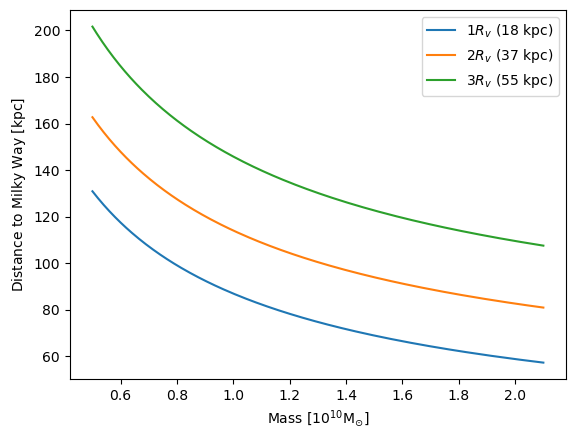

In [65]:
"""
Tidal radius is the radius of the projenitor such that 
the material outside that radius gets stripped. In this 
plot, I am calculating at what distance would the tidal
radius be at n times the virial radius. 
"""

all_rs = []
for i in range(len(Rs_Leo)):

    r_tidal = []
    for M in Mstar_Leo:
        LeoPotential = pot.PseudoIsothermalPotential(amp = M*u.Msun, a = 5e1*core_Leo*u.kpc)
        r = tidal_radius(LeoPotential, MWPotential, Rs_Leo[i])
        r_tidal.append(r)
    
    r_tidal = np.asarray(r_tidal)
    
    print("Plot Commencing")
    plt.plot(Mstar_Leo/(1e10), r_tidal, label = f"${i+1}R_v$ ({round(Rs_Leo[i])} kpc)")
    plt.xlabel(r"Mass [$10^{10} \mathrm{M}_{\odot}$]")
    plt.ylabel(r"Distance to Milky Way [$\mathrm{kpc}$]")
    
    
    all_rs.append(r_tidal)
    
plt.legend()

# Initializing Orbit

In [8]:
#Parameter Block
#Orbit Initial Conditions
orb = Orbit.from_name('Leo I')

print(orb.ra(),orb.dec(),orb.dist())
print(orb.vlos)

ts = np.linspace(0,-4,101)*u.Gyr #every 10Myr

#No DF orbit
orb.integrate(ts, MWPotential)

152.1146 12.30589999999999 258.2
<bound method Orbit.vlos of <galpy.orbit.Orbits.Orbit object at 0x7f1d62758810>>


Plot Commencing
Plot Commencing
Plot Commencing


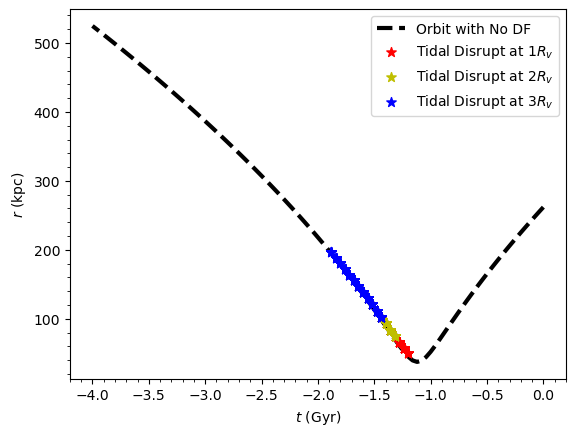

In [9]:
orb.plot(d1='t',d2='r', color="k", linewidth=3, linestyle="dashed", label=r'Orbit with No DF')

colors = ["r","y","b"]

for i in range(len(Rs_Leo)):
    #The tidals at said virial radii 
    rs = all_rs[i]
    
    t_begins = []
    dists = []
    for r in rs:
        #Get time where obect was first within distance
        t_begin = dist_to_time(orb, r, ts, False)[1]
        #Get the corresponding distance to the object at that times
        dist = time_to_dist(orb, [t_begin]*u.Gyr)
        
        t_begins.append(t_begin)
        dists.append(dist)
        
    print("Plot Commencing")
    plt.scatter(t_begins, dists, marker = "*", color=colors[i], s = 50, zorder=10, label = f"Tidal Disrupt at ${i+1} R_v$")

plt.legend()

In [72]:
def random_seq(seq1, seq2, k):
    """
    returns sequence 1 in which some k numbers
    from sequence 2 are randomly added or 
    subtracted to sequence 1 (acc. to index).
    Both sequences should be the same size.
    """
    seq = seq1.copy() #Assigning new list to not touch other list
    pop = range(len(seq))
    idx = ran.sample(pop, k)
    
    for i in idx:
        oper = ran.randint(0,1)
        if oper == 0:
            seq[i] += seq2[i]
        elif oper == 1:
            seq[i] -= seq2[i]
   
    return seq 

def mult_orb(pos, vel, pos_sig, vel_sig, time_array, number, plotting):
    """
    Creates a number [number argument] of orbits of 
    an object based on the current best values of its 
    initial conditions as well as uncertainties. New 
    orbits are made by (psuedo) randomly adding or 
    subtracting the uncertainty of some randomly 
    selected numbers of parameters. 
    
    Inputed values should be:
    pos = [ra(deg), dec(deg), dist(kpc)]
    vel = [mu_ra(mas/yr), mu_dec(mas/yr), vlos(km/s)]
    and same for errors. This is to match the galpy 
    documentation, but any other list of pos and vel
    that matches the documentation should work as well. 
    https://docs.galpy.org/en/v1.7.2/reference/orbitinit.html
    
    THE MAXIMUM NUMBER OF ORBITS CONCEIVED BY THIS METHOD IS
    729. DON'T REQUEST OVER 729 ORBITS. 
    """
    if number > 729:
        print("You done goofed")
    
    #1) Define initial conditions (IC) and error (sigma)
    IC = pos + vel
    sigma = pos_sig + vel_sig
    rang = len(IC) #should be 6
    
    #2) If enabled, plot best fit orbit
    orb_best = Orbit(vxvv=IC, radec=True)
    orb_best.integrate(time_array, MWPotential)
    orb_best.plot(d1='x',d2='y', color="k", linewidth=3, linestyle="dashed", 
                 label=r'Best Fit Orbit', zorder=10)
    plt.legend()
    
    #3) Create various number of unique ICs
    ICs = []
    i = 0
    print("Creating ICs...")
    while len(ICs) <= number-1: 
        k = ran.randint(0,6)
        IC_new = random_seq(IC, sigma, k)
        if IC_new in ICs:
            i += 1
        else:
            ICs.append(IC_new)
        #    print(f"# of ICs is {len(ICs)}")
    print(f"repeated ICs = {i}")
                
    #4) Use these ICs to create unique orbits and plots
    orbs = []
    print("initializing orbits...")
    for ic in ICs:
        orb = Orbit(vxvv=ic, radec=True)
        orb.integrate(time_array, MWPotential)
        orbs.append(orb)
        
    #4.5)Plot if specified
        if plotting == True:
            orb.plot(d1='x',d2='y', linewidth=1, linestyle="dashed", overplot=True)
    
    #5) Return the Cs at the end of each orbit at -4 Gyr ago
    poss_past = []
    vels_past = []
    for orb in orbs:
        pos_past = [orb.x(time_array[-1]), orb.y(time_array[-1]), orb.z(time_array[-1])]
        vel_past = [orb.U(time_array[-1]), orb.V(time_array[-1]), orb.W(time_array[-1])]
        poss_past.append(pos_past)
        vels_past.append(vel_past)
    
   # if plotting == True:
   #     plt.legend()
    
    return poss_past, vels_past

152.1146 12.30589999999999 258.2
-0.0503729254682685 -0.11982637025844439 282.90000000000003
Creating ICs...
repeated ICs = 7969
initializing orbits...


Text(0.5, 1.0, 'Possible Orbits of Leo I')

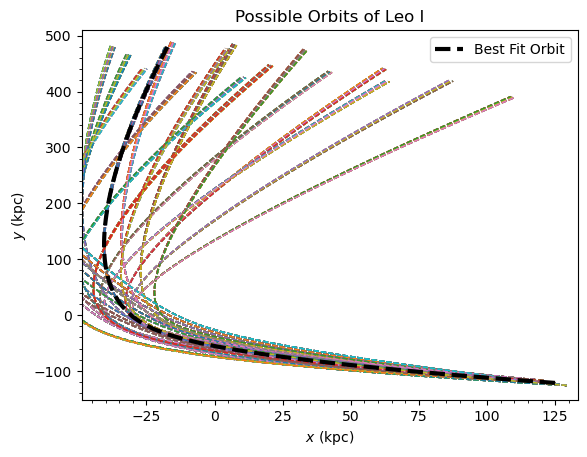

In [73]:
#RA & Dec from Munoz et al. 2018
#Velocities and distance from Pace et al. 2022 (from GAIA EDR3)
pos = [152.1146, 12.3059, 258.2]
vel = [-0.05, -0.12, 282.9]
pos_sig = [5e-4, 0.005, 9.5]
vel_sig = [0.014, 0.01, 0.5]
IC = pos + vel
sigma = pos_sig + vel_sig

off_orb = Orbit.from_name("Leo I")
print(off_orb.ra(), off_orb.dec(), off_orb.dist())
print(off_orb.pmra(), off_orb.pmdec(), off_orb.vlos())
Cs = mult_orb(pos,vel,pos_sig,vel_sig, ts, 729, True)
plt.title("Possible Orbits of Leo I")

In [76]:
def better_multorb(pos, vel, pos_sig, vel_sig, time_array, number, plotting):
    """
    Samples a number [number argument] of orbits of 
    an object based on the current best values of its 
    initial conditions as well as uncertainties. New 
    orbits are made by sampling initial conditions 
    assuming a Gaussian distribution. 
    
    Inputed values should be:
    pos = [ra(deg), dec(deg), dist(kpc)]
    vel = [mu_ra(mas/yr), mu_dec(mas/yr), vlos(km/s)]
    and same for errors. This is to match the galpy 
    documentation, but any other list of pos and vel
    that matches the documentation should work as well. 
    https://docs.galpy.org/en/v1.7.2/reference/orbitinit.html
    """
    
    #0) Define initial conditions (IC) and error (sigma)
    IC = pos + vel
    sigma = pos_sig + vel_sig
    size = len(IC)
    
    #1) If enabled, plot best fit orbit
    orb_best = Orbit(vxvv=IC, radec=True)
    orb_best.integrate(time_array, MWPotential)
    orb_best.plot(d1='x',d2='y', color="k", linewidth=3, linestyle="dashed",
                  zorder=10, label=r'Best Fit Orbit')
    plt.legend()
    
    #2) Get normally distributed values of ICs
    print("Getting randos...")
    ICs = np.zeros((number,size))
    for i in range(number):
        b = np.random.normal(loc = IC, scale = sigma, size=None)
        ICs[i] = b
    
    #3) Use these ICs to create unique orbits and plots
    orbs = []
    print("initializing orbits...")
    for ic in ICs:
        orb = Orbit(vxvv=ic, radec=True)
        orb.integrate(time_array, MWPotential)
        orbs.append(orb)
        
    #4)Plot if specified
        if plotting == True:
            orb.plot(d1='x',d2='y', linewidth=0.5, linestyle="dotted", color="grey", overplot=True)
    
    #5) Return the Cs at the end of each orbit at -4 Gyr ago
    poss_past = []
    vels_past = []
    for orb in orbs:
        pos_past = [orb.x(time_array[-1]), orb.y(time_array[-1]), orb.z(time_array[-1])]
        pos_past_galcen = coords.XYZ_to_galcenrect(pos_past[0], pos_past[1], pos_past[2])
        vel_past = [orb.U(time_array[-1]), orb.V(time_array[-1]), orb.W(time_array[-1])]
        poss_past.append(pos_past_galcen)
        vels_past.append(vel_past)
    
    return poss_past, vels_past

Getting randos...
initializing orbits...
([(10.002437169535435, 491.6951526671055, -189.0274477489192), (191.24088130637406, 463.25239185193664, -147.41696939252955), (11.684403483472101, 426.35483951331224, -310.7146721264107), (122.94128323433807, 478.9363411309119, -169.34130771264424), (3.5518106649256054, 473.3923151552491, -222.3441430670296), (42.43672071928938, 460.81968850651276, -256.7896614643117), (140.99404541013558, 489.00304304597, -126.35554496565902), (-37.558901213477974, 373.83563121485827, -376.85504924419354), (-87.75466588305346, 333.93325553768113, -390.8592979627243), (-48.78928016788444, 449.1404209463543, -269.5556609099622), (-51.3513280622972, 386.4243708842088, -354.12742818184114), (122.69020896365578, 493.06531962226796, -119.56998624655503), (-68.97669743991551, 420.53073654413976, -308.5518087348692), (225.36448974235785, 434.5396573331358, -194.9933552231388), (83.39346364697028, 461.2972331625981, -231.22639282479392), (38.0841837939947, 476.277445212

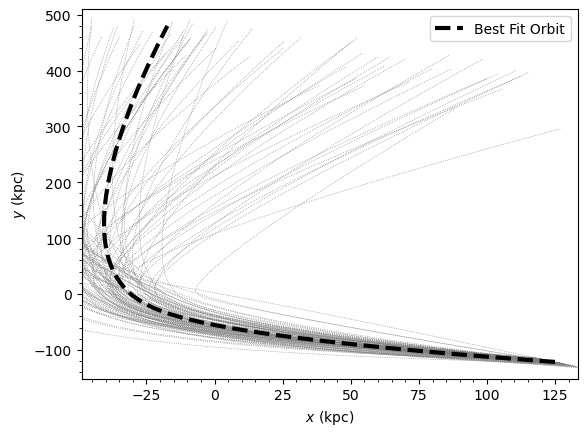

In [77]:
Cs = better_multorb(pos,vel,pos_sig,vel_sig, ts, 100, True)
print(Cs)

In [71]:
for h in range(20):
    i = ran.randint(0,len(Cs[0]))
    print(Cs[0][i],Cs[1][i])

(-1.4914798617017646, 430.53231375020096, -305.3604942237328) [16.179104571069217, -351.2768643938304, 53.92068617394869]
(-6.378776279461092, 480.84035972030546, -209.25126226000376) [5.1510598521933515, -352.4075421776801, 28.763297205040416]
(91.62489481779009, 485.4351008212054, -180.12088780156134) [-18.143248175788017, -362.559791237844, 15.608065223896784]
(96.31271679444956, 476.8846849503977, -197.0088206587612) [-16.94080999177803, -358.3117325822912, 16.96756067421471]
(126.78629075751647, 492.55054539069357, -124.40437625598572) [-30.732673104686356, -357.4929957096667, 2.690422567737907]
(128.7401892212443, 473.24724948716556, -184.0556728920663) [-27.39249406726265, -362.4553059045547, 13.036218773149155]
(197.25009408237798, 461.9832672961244, -139.14337741983022) [-50.273472083007704, -358.84607916130517, -0.8244448669100868]
(145.18084250422007, 486.55973026186547, -135.91019455438996) [-34.35651976068208, -357.7771873297223, 2.525939673692705]
(98.6820096144212, 487.7